# Emotion Analysis for Interstellar
![Changing Emotion](image.png)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA Server
We are reusing the start server notebook for launching the EVA server

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

Note: you may need to restart the kernel to use updated packages.


## Downloading the video files

In [2]:
# Link for movie_clip
!wget -nc https://www.dropbox.com/s/xdlnctyry1p3xwr/interstellar.mp4

# Links for UDFs
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/emotion_detector.py

--2022-09-28 21:19:59--  https://www.dropbox.com/s/xdlnctyry1p3xwr/interstellar.mp4
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xdlnctyry1p3xwr/interstellar.mp4 [following]
--2022-09-28 21:20:00--  https://www.dropbox.com/s/raw/xdlnctyry1p3xwr/interstellar.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a48a10c5a87ab505da30350c6.dl.dropboxusercontent.com/cd/0/inline/Bt2HE25XJcabw81V8F2ppZSxqF8FmG-4ezWNP2GVLORlRey7WhfLO7jXt7QCAgtT6iTqx753A-rftx-bF03tmlq6DJiAYQVOyHpIzCxXdLUkrNrOLN7ZC0DC1KGFRthy8mHdfWy5VF-Vx4Sl-QejXfHxGqRo6vNaUYD_zB0uCQHNYg/file# [following]
--2022-09-28 21:20:00--  https://uc2a48a10c5a87ab505da30350c6.dl.dropboxusercontent.com/cd/0/inline/Bt2HE25XJcabw81V8F2ppZSxqF8FmG-4ezWNP2GVLORlRey7WhfLO7jXt7QCAgtT6iTq

# Visualize Video Clip

In [ ]:
from IPython.display import Video
Video("interstellar.mp4", height=450, width=800, embed=True)

## Loading the video files in EVA

In [3]:
# Adding the movies to eva
cursor.execute('drop table if exists interstellar')
response = cursor.fetch_all()

cursor.execute('load file "interstellar.mp4" into interstellar')
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  Video successfully added at location: interste...
@batch_size: 1
@identifier_column: None
@query_time: 0.14647679403424263


## Defining the User-Defined Functions (UDF)

In [4]:
# Defining the UDFs
cursor.execute("""CREATE UDF IF NOT EXISTS EmotionDetector 
        INPUT (frame NDARRAY UINT8(3, ANYDIM, ANYDIM)) 
        OUTPUT (labels NDARRAY STR(ANYDIM), scores NDARRAY FLOAT32(ANYDIM)) 
        TYPE  Classification IMPL 'emotion_detector.py';
        """)
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:                                                    0
0  UDF EmotionDetector already exists, nothing ad...
@batch_size: 1
@identifier_column: None
@query_time: 0.01030641421675682
@status: 0
@batch: Batch Object:
@dataframe:                                                  0
0  UDF FaceDetector already exists, nothing added.
@batch_size: 1
@identifier_column: None
@query_time: 0.005051605403423309


## Extract Emotions of all the faces in the movie clip

In [6]:
cursor.execute(f"""SELECT id, Face.bbox, Emotion.label 
                   FROM  interstellar 
                      JOIN LATERAL  Unnest(FaceDetector(data)) AS Face(bbox, conf) 
                      JOIN LATERAL EmotionDetector(Crop(data, bbox)) AS Emotion (label, conf)
                   WHERE Face.conf > 0.75 AND Emotion.conf > 0.5;
                """
               )
response = cursor.fetch_all()
print(response)

@status: 0
@batch: Batch Object:
@dataframe:       interstellar.id                                          Face.bbox  \
0                  22  [288.0761413574, 273.5796508789, 344.327575683...   
1                  33  [155.6334838867, 388.8661193848, 186.373138427...   
2                 121  [247.7004852295, 135.6897277832, 400.374084472...   
3                 143  [512.4508056641, 222.2551269531, 536.977783203...   
4                 144  [511.5243835449, 223.1337432861, 536.326477050...   
...               ...                                                ...   
5907             7627  [438.9408874512, 100.0564422607, 714.339294433...   
5908             7628  [429.6116943359, 98.9550857544, 715.0719604492...   
5909             7629  [425.7778015137, 85.107749939, 709.5927124023,...   
5910             7634  [431.116607666, 105.1298217773, 725.7129516602...   
5911             7635  [414.4948730469, 125.1558074951, 687.877014160...   

     Emotion.label  
0          neutral  


## Visualizing the distribution of emotions 

<AxesSubplot:title={'center':'Emotion Palette for interstellar clip'}, ylabel='interstellar.id'>

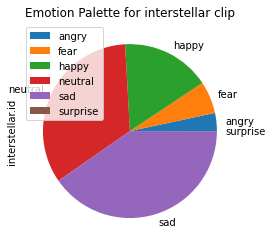

In [7]:
df = response.batch.frames
df.groupby(['Emotion.label']).count().plot(kind='pie', y = 'interstellar.id', title="Emotion Palette for interstellar clip")

## Identify instances with changing emotions

In [8]:
import numpy as np
emotions = df['Emotion.label'].to_numpy()
ids = df['interstellar.id'].to_numpy()

data = zip(ids, emotions)
from itertools import groupby
emotes = [list(j) for i, j in groupby(data, lambda x: x[1])]
emotion_groups = []
for item in emotes:
    start = item[0][0]
    end = item[-1][0]
    emote = item[0][1]
    if (end - start > 50):
        emotion_groups.append((start, end, emote))
prev = emotion_groups[0]
changing_emotions = set()
for item in emotion_groups[1:]:
    if item[2] != prev[2]:
        changing_emotions.add(prev)
        changing_emotions.add(item)
    prev = item
change_idxs = sorted([np.random.randint(a,b) for a,b, _ in changing_emotions])

In [9]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
import ast

def img_show(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

def view_frames(video_path, frame_data, id_name):
    color1=(207, 248, 64)
    color2=(0, 0, 255)
    thickness=4
    
    vcap = cv2.VideoCapture(video_path)
    frame_id = 0
    ret, frame = vcap.read()
    while ret:
        df = frame_data[frame_data[id_name] == frame_id]
        img = frame
        if df.size:
            label = df['Emotion.label'].tolist()[0]
            x1,y1,x2,y2 = df['Face.bbox'].tolist()[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            img=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
            # object label
            cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
            # frame label
            cv2.putText(img, 'Frame ID: ' + str(frame_id), (900, 1000), cv2.FONT_HERSHEY_SIMPLEX, 2.4, color2, thickness) 
           
            img_show(img)
            
        frame_id +=1
        ret,frame = vcap.read()
    vcap.release()

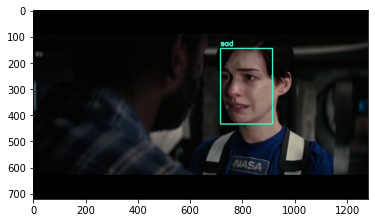

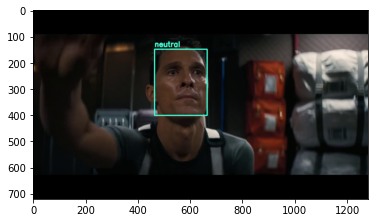

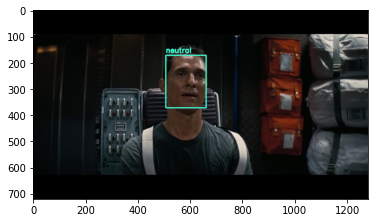

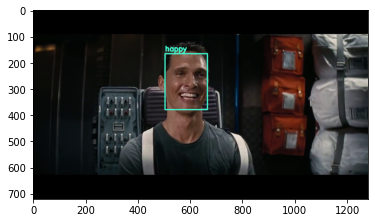

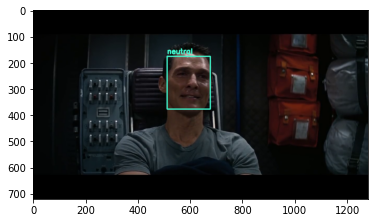

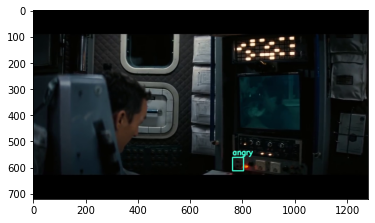

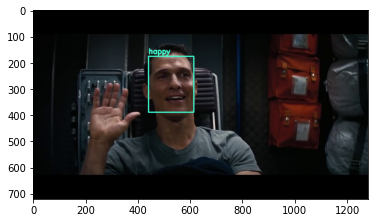

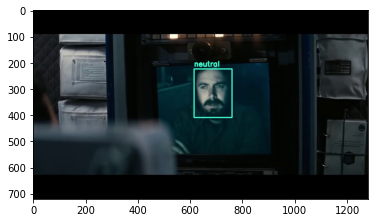

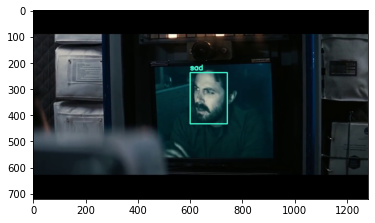

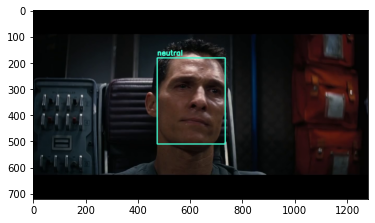

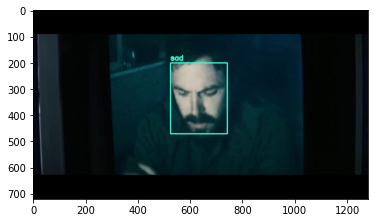

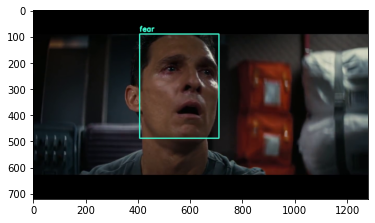

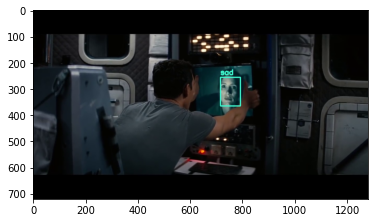

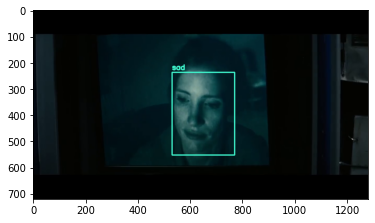

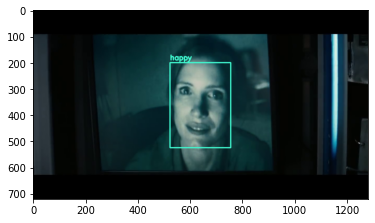

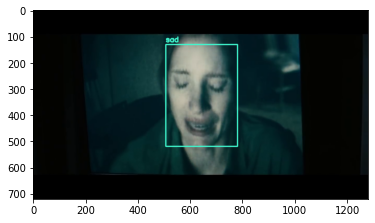

In [11]:
interesting_frames = df.loc[df['interstellar.id'].isin(change_idxs)]
input_path = f'./interstellar.mp4'
id_name = f'interstellar.id'
view_frames(input_path, interesting_frames, id_name)